In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing

In [3]:
data = pd.read_csv('/content/drive/MyDrive/SkillFactory/Machine Learning/ML-4. Обучение без учителя: кластеризация и техника понижения размерности/segmented_customers.csv')
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,1,Male,19.0,15.0,39.0,4.0
1,2,Male,21.0,15.0,81.0,3.0
2,3,Female,20.0,16.0,6.0,4.0
3,4,Female,23.0,16.0,77.0,3.0
4,5,Female,31.0,17.0,40.0,4.0


Проведём предобработку данных: удалим пропуски и дубли, признак Gender превратим в бинарный с помощью LabelEncoder:


In [6]:
# посмотрим есть ли пропуски в датасете
data[data.isna().any(axis=1)]

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
200,201,Female,21.0,NaN,40.0,0.0
201,202,Female,30.0,127.0,NaN,NaN
202,203,Male,80.0,NaN,20.0,NaN
203,204,Male,NaN,16.0,120.0,NaN
204,205,Female,NaN,9.0,80.0,NaN


In [8]:
# пропусков не так много, поэтому мы можем удалить данные с пропусками
data = data.dropna()

# переименуем столбцы для более удобной работы
data.rename(columns = {'CustomerID': 'customer_id', 'Gender': 'gender', 'Age': 'age', \
                       'Annual Income (k$)': 'annual_income', 'Spending Score (1-100)': 'spending_score'},
            inplace = True)

In [10]:
# проверим, есть ли в данных дубликаты
data[data.duplicated(subset=['customer_id'])]
# Дубликатов нет, поэтому идём дальше

,customer_id,gender,age,annual_income,spending_score,cluster


In [12]:
import plotly
import plotly.express as px

fig = px.scatter_3d(
    data_frame = data,
    x = 'age',
    y = 'annual_income',
    z = 'spending_score',
    width=1000,
    height=700
)

fig.show()

In [13]:
def get_3d_visualization(df, clust_res):
  fig = px.scatter_3d(
      data_frame=df,
      x = 'age',
      y = 'annual_income',
      z = 'spending_score',
      color = clust_res,
      width=1000,
      height=700
  )

  return fig

In [14]:
# Сохраним признаки, по которым будем проводить моделирование, в переменную X:
X = data[['age', 'annual_income', 'spending_score']]

In [18]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN()
predictions = clustering.fit_predict(X=X)

In [22]:
data['dbscan_result'] = predictions
get_3d_visualization(data, 'dbscan_result')

In [25]:
# импортируем DBSCAN-кластеризацию
from sklearn.cluster import DBSCAN

#запускаем кластеризацию на наших данных
dbscan = DBSCAN(eps=11)
clustering_dbscan_res = dbscan.fit_predict(X)
data['dbscan_res_eps_11'] = clustering_dbscan_res

get_3d_visualization(data, 'dbscan_res_eps_11')

In [30]:
from sklearn.cluster import AgglomerativeClustering

def get_aggl_clustering(X, n_clusters):
  aggl_clust = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')

  aggl_clust.fit(X)

  aggl_pred = aggl_clust.labels_

  return aggl_pred

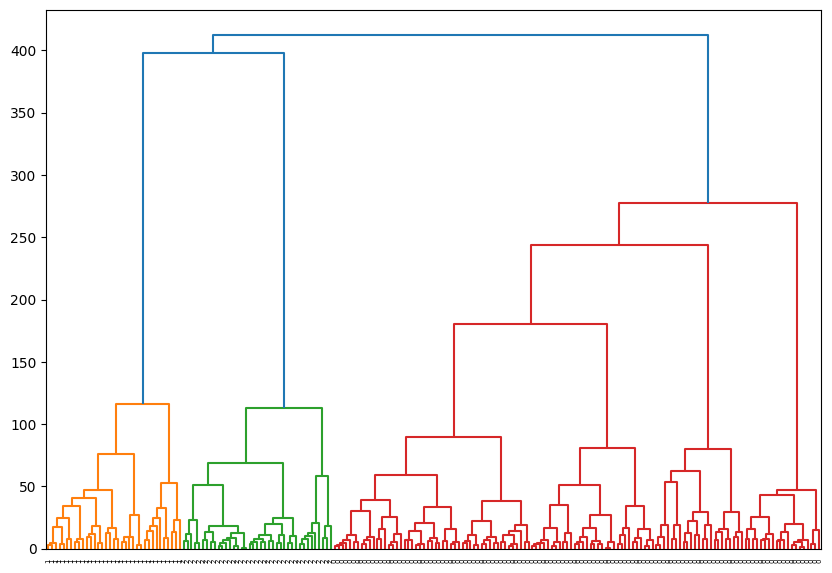

In [35]:
# импортируем библиотеку scipy, чтобы визуализировать дендрограмму
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

# запускаем агломеративную кластеризацию и сохраним результаты в df
data['aggl_res_3'] = get_aggl_clustering(X, 3)

linked = linkage(X, 'ward')
plt.figure(figsize=(10, 7))

dendrogram(linked,
            orientation='top',
            labels=data['aggl_res_3'].to_list(),
            distance_sort='descending',
            show_leaf_counts=True)

plt.show()

In [37]:
data['aggl_clust_6'] = get_aggl_clustering(X, 6)
get_3d_visualization(data, 'aggl_clust_6')

<Axes: xlabel='Number of clusters (k)', ylabel='PCA weighted mean of the clusters'>

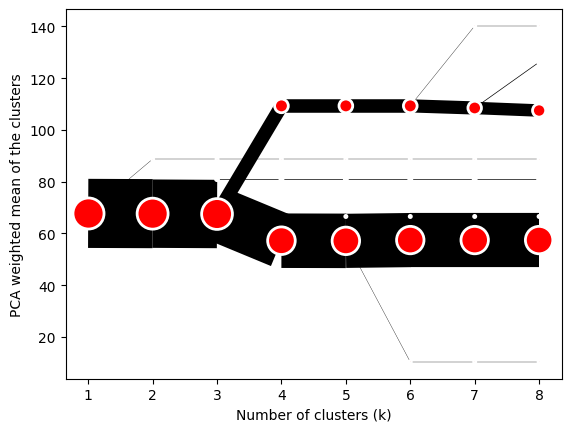

In [41]:
from clustergram import Clustergram

# задаем количество кластеров, для которого хотим получить визуализиацию
cgram = Clustergram(range(1, 9), method='hierarchical')
# запускаем алгоритм
cgram.fit(X)
cgram.plot()

<Axes: xlabel='cluster', ylabel='silhouette'>

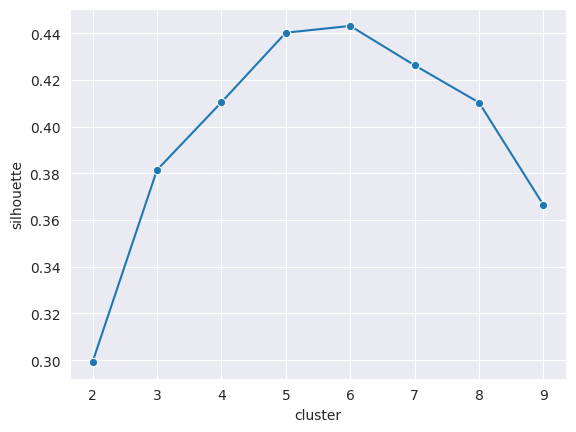

In [42]:
from sklearn.metrics import silhouette_score
import seaborn as sns

# напишем функцию для подсчёта коэффициента силуэта
def get_silhouette_agg_clust(X, cluster_num):
    # проведём агломеративную кластеризацию с заданным количеством кластеров
    res = get_aggl_clustering(X, cluster_num)
    # рассчитаем коэффициент силуэта
    silhouette = silhouette_score(X, res)
    return silhouette


# создадим пустой словарь, ключами будут коэффициент силуэта и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}


for cluster_num in range(2, 10):
    silhouette_res["silhouette"].append(get_silhouette_agg_clust(X, cluster_num))
    silhouette_res["cluster"].append(cluster_num)

# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

# установим стиль для визуализиции
sns.set_style("darkgrid")
# визуализируем зависимость значения инерции от количества кластеров
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker="o")

In [43]:
from sklearn.metrics.cluster import completeness_score

print(completeness_score(labels_true=data.cluster, labels_pred=data.aggl_clust_6))
# 0.9012847747610448

0.9012847747610448
